In [1]:
'''正解データ（スランプ値が20.0）の動画はIOHD0017とする'''
import Function

sec_ranges = [(48, 53), (30, 35), (45, 50), (40, 45)]
Function.ExtractFramesFromMultipleVideos(sec_ranges)

In [21]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

try:
    # 画像の数字データを格納する配列
    x_data = []
    # 正解ラベル
    y_data = []
    # 入力データの形状
    input_shape = [256, 256, 3]
    # 学習データ画像が保存されているディレクトリパス
    image_dir = '../data/Movie'

    # "IOHD"で始まるディレクトリを探索
    for sub_dir in sorted(os.listdir(image_dir)):
        sub_dir_path = os.path.join(image_dir, sub_dir)
        if os.path.isdir(sub_dir_path) and sub_dir.startswith("IOHD"):
            # 各サブディレクトリ内のjpgファイルを読み込む
            for filename in sorted(os.listdir(sub_dir_path)):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(sub_dir_path, filename)
                    img = load_img(img_path, target_size=input_shape)
                    img_array = img_to_array(img) / 255.0
                    x_data.append(img_array)
                    if sub_dir == "IOHD0018":
                        y_data.append(1)
                    else:
                        y_data.append(0)


    # 正規化
    x_data = np.array(x_data, dtype="float32")
    y_data = np.array(y_data, dtype="float32")
    
    # 確認
    print(x_data.shape)
    print(len(y_data))

except Exception as e:
    print(f"エラー発生：{e}")

(1198, 256, 256, 3)
1198


In [22]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータ（モデルの評価に使用）に分割
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

def make_convlayer(x_train):
    model = Sequential()

    # 第1層：畳み込み層1
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=x_train[0].shape,
            padding="same",
            activation="relu"
        ))
    # 第2層：畳み込み層2
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        ))
    # 第3層：プーリング層1
    model.add(MaxPooling2D(pool_size=(2,2)))
    # ドロップアウト1
    model.add(Dropout(0.3))
    # 第4層：畳み込み層3
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        ))
    # 第5層：畳み込み層4
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding="same",
            activation="relu"
        ))
    # 第6層：プーリング層2
    model.add(MaxPooling2D(pool_size=(2,2)))
    # ドロップアウト2
    model.add(Dropout(0.3))
    # Flatten：4階テンソルから2階テンソルに変換
    model.add(Flatten())
    # 第7層：全結合層
    model.add(Dense(128,
                    activation="relu"))
    # ドロップアウト3
    model.add(Dropout(0.5))
    # 第8層：出力層
    model.add(Dense(1,
                    activation="sigmoid"))
    
    # Sequentialオブジェクトのコンパイル
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.Adam(0.001),
        metrics=["accuracy"]
    )

    return model

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def train(x_train, x_test, y_train, y_test):
   # val_accuracyの改善が５エポック見られなかったら、学習率を0.5倍する
   reduce_lr = ReduceLROnPlateau(
      monitor="val_accuracy",   # 監視対象は検証データの精度
      factor=0.5,               # 学習率を減衰させる割合
      patience=5,
      verbose=1,
      mode="max",               # 最高値を監視する
      min_lr=0.0001             # 学習率の下限
   )
   
   model = make_convlayer(x_train)
   model.summary()

   callbacks_list = [reduce_lr]

   batch_size = 32
   epochs = 15

   # 学習
   history = model.fit(
      x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_split=0.2,      # 検証データの作成
      shuffle=True,              
      callbacks=callbacks_list
   )
   # テストデータでモデルを評価
   score = model.evaluate(x_test, y_test, verbose=0)
   # テストデータの損失を出力
   print(f"Test loss：{score[0]}")
   # テストデータの精度を出力
   print(f"Test accuracy：{score[1]}")

   return model, history

model, history = train(x_train, x_test, y_train, y_test)

/home/ruka/anaconda3/envs/Test3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,620,257 (128.25 MB)

 Trainable params: 33,620,257 (128.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


2024-10-09 12:47:32.735499: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602406912 exceeds 10% of free system memory.


24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6849 - loss: 4.5114 - val_accuracy: 0.7812 - val_loss: 0.5598 - learning_rate: 0.0010
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.7466 - loss: 0.5757 - val_accuracy: 0.7812 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.7341 - loss: 0.5825 - val_accuracy: 0.7812 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7216 - loss: 0.5998 - val_accuracy: 0.7812 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7351 - loss: 0.5933 - val_accuracy: 0.7812 - val_loss: 0.5171 - learning_rate: 0.0010
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7272 - loss: 0.6193
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7277 - loss: 0.6180 - val_accuracy: 0.7812 - val

In [25]:
import io

save_dir = "../output/Test_CNN_SrumpToBinaryClass/CNN1/19"
# ディレクトリが存在しない場合は作成
os.makedirs(save_dir, exist_ok=True)

# 出力をキャプチャするためのStringIO
buffer = io.StringIO()

# model.summary()の出力をbufferに書き込む
model.summary(print_fn=lambda x: buffer.write(x + "\n"))

# キャプチャした内容をファイルに保存
with open(os.path.join(save_dir, "model_summary.txt"), "w") as f:
    f.write(buffer.getvalue())

# StringIOのメモリを開放
buffer.close()


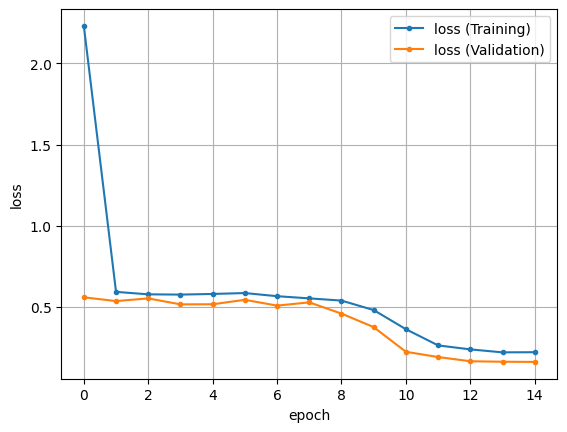

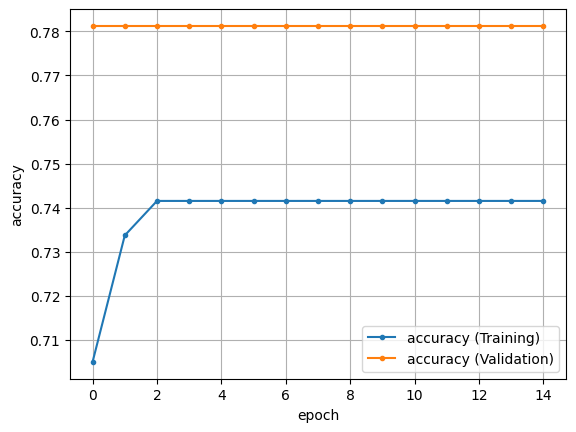

In [26]:
# 訓練データの損失をプロット
plt.plot(history.history["loss"],
         marker=".",
         label="loss (Training)")
# 検証データの損失をプロット
plt.plot(history.history["val_loss"],
         marker=".",
         label="loss (Validation)")
plt.legend()        # 凡例を表示
plt.grid()          # グリット表示
plt.xlabel("epoch") # x軸ラベル
plt.ylabel("loss")  # y軸ラベル損失関数はモデルが出力した確率分布と実際のラベルとの「距離」を計算するもので、分類タスクでは交差エントロピー損失などがよく使われます。
# 損失のグラフを保存
plt.savefig(os.path.join(save_dir, "loss.jpg"))
plt.show()

# 訓練データの精度をプロット
plt.plot(history.history["accuracy"],
         marker=".",
         label="accuracy (Training)")
# 検証データの精度をプロット
plt.plot(history.history["val_accuracy"],
         marker=".",
         label="accuracy (Validation)")
plt.legend()        # 凡例を表示
plt.grid()          # グリット表示
plt.xlabel("epoch") # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.savefig(os.path.join(save_dir, "accuracy.jpg"))
plt.show()

In [27]:
model_path = os.path.join(save_dir, "model.json")
param_path = os.path.join(save_dir, "weight.weights.h5")

# モデルをmodel.jsonとして保存
with open(model_path, "w") as json_file:
    json_file.write(model.to_json())                                # モデルをJSON形式に変換して保存
# パラメーターをweight.h5として保存
model.save_weights(param_path)     # HDF5形式で保存

In [28]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image

# モデルの読み込み
model_r = model_from_json(open(model_path, "r").read())
# 重みの読み込み
model_r.load_weights(param_path)
# Sequentialオブジェクトのコンパイル
model_r.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(0.001), metrics=["accuracy"])

# 予測したい画像パス
image_path = "../data/Movie/IOHD0017/frame_2806.jpg"
# 画像のロード
img = image.load_img(image_path, target_size=(256, 256))
# 配列に変換
img_array = image.img_to_array(img)
# 次元数の追加（256, 256, 3） -> (1, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)
# 正規化
img_array /= 255.0

prediction = model_r.predict(img_array)
prediction_bool = prediction[0][0] > 0.5
print("予測結果：", prediction_bool)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
予測結果： False
